## DATA 620 

---
### Project 1 - Alt
### Mael Illien and Jeremy OBrien

In [42]:
import csv
import foursquare
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from config import foursquare_config as fs_config

In [6]:
midtown = pd.read_csv('venues_midtown_unique.csv')
downtown = pd.read_csv('venues_downtown.csv')
westvil = pd.read_csv('venues_westvil_unique.csv')

In [122]:
# Cleanup datasets
midtown = midtown.filter(items=['id', 'name','type'])
downtown = downtown.drop_duplicates()
downtown = downtown.filter(items=['id', 'name','type'])
downtown = downtown.reset_index()
westvil = westvil.filter(items=['id', 'name','type'])

In [4]:
print(len(midtown))
midtown.head(10)

21


,id,name,type
0,43695300f964a5208c291fe3,Empire State Building,Building
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout
2,49b7ed6df964a52030531fe3,Times Square,Plaza
3,41102700f964a520d60b1fe3,Macy's,Department Store
4,40b68100f964a5207d001fe3,Madison Square Park,Park
5,3fd66200f964a520d7f11ee3,Bryant Park,Park
6,50b6ed46e4b0a40f1ec2ab32,102nd Floor Observatory,Scenic Lookout
7,4a065273f964a520ec721fe3,M&M's World,Candy Store
8,428a8580f964a52083231fe3,Hard Rock Cafe,Theme Restaurant
9,49b79f54f964a5202c531fe3,Rockefeller Center,Plaza


In [123]:
print(len(downtown))
downtown.head(10)

23


,index,id,name,type
0,0,4abe7f9ef964a520068e20e3,One World Trade Center,Building
1,1,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site
2,2,515abd65e4b08eda86b30e6e,One World Observatory,Scenic Lookout
3,3,49ff62f9f964a52013701fe3,Century 21 Department Store,Department Store
4,4,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge
5,5,4a6fa0abf964a520a4d61fe3,Brookfield Place (BFPL),Mall
6,9,42daf100f964a52035261fe3,Battery Park,Park
7,16,55edd0ef498e4b104d071a87,One Dine,New American
8,17,5984eeb39be522744003dee5,Oculus Plaza,Plaza
9,20,4b7de017f964a52049d82fe3,Starbucks,Coffee Shop


In [9]:
print(len(westvil))
westvil.head(10)

25


,id,name,type
0,40abf500f964a52035f31ee3,Washington Square Park,Park
1,3fd66200f964a520def11ee3,Union Square Park,Park
2,4caf3aa3b4b0a35db3273fce,Washington Square Fountain,Fountain
3,44dc96e4f964a520b0361fe3,Think Coffee,Coffee Shop
4,4af281eaf964a520d2e721e3,Starbucks,Coffee Shop
5,40f1d480f964a5206a0a1fe3,High Line,Park
6,43fe1ba4f964a520f82f1fe3,Barnes & Noble,Bookstore
7,43bba61df964a520eb2c1fe3,Whole Foods Market,Grocery Store
8,4a8cc1d4f964a520130f20e3,Strand Bookstore,Bookstore
9,49c27575f964a520f1551fe3,Union Square Greenmarket,Farmer's Market


In [15]:
midtown['id'][0]

'43695300f964a5208c291fe3'

In [7]:
midtown[midtown['id'] == '43695300f964a5208c291fe3']

,id,name,type
0,43695300f964a5208c291fe3,Empire State Building,Building


In [10]:
# Fill these out to run but don't save to Github
CLIENT_ID = fs_config['id']
CLIENT_SECRET = fs_config['secret']

client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [125]:
def generate_links(locations):
    links = []

    for l in locations['id']:
        #print(l)
        next_locations = client.venues.nextvenues(l)['nextVenues']['items']
        
        for nl in next_locations:
            link = (l, nl['id'])
            #print(link)
            if not link in links:
                #if nl['id'] in locations['id']:
                    #print('adding link')
                links.append(link)          
    return links

def generate_network_from_locations(locations):
    #labels = dict(zip(list(venues['id']),list(venues['name'])))
    links = generate_links(locations)
    #print(links)
    
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
    return G

def generate_network_from_links(venues, links_file):
    # Read links from file which are stored a str representation of tuples
    links = []
    with open(links_file, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            as_tpl = eval(row[0])
            links.append(as_tpl)
    
    # Create graph
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
        
    # Add attributes to the nodes
    for i in range(len(venues)):
        ven_id = venues['id'][i]
        G.nodes[ven_id]['name'] = venues['name'][i]
        G.nodes[ven_id]['type'] = venues['type'][i]
    # Trim nodes of degree 1 or less
    #small = [n for n in G.nodes if G.degree[n] <= 1]
    #G.remove_nodes_from(small)
        
    return G

In [116]:
#midtown_g = generate_network_from_locations(midtown)
midtown_g = generate_network_from_links(midtown, 'links_midtown.csv')
print(nx.info(midtown_g))

Name: 
Type: DiGraph
Number of nodes: 46
Number of edges: 105
Average in degree:   2.2826
Average out degree:   2.2826


In [110]:
# Make figures bigger
plt.rcParams['figure.figsize'] = [20, 10]

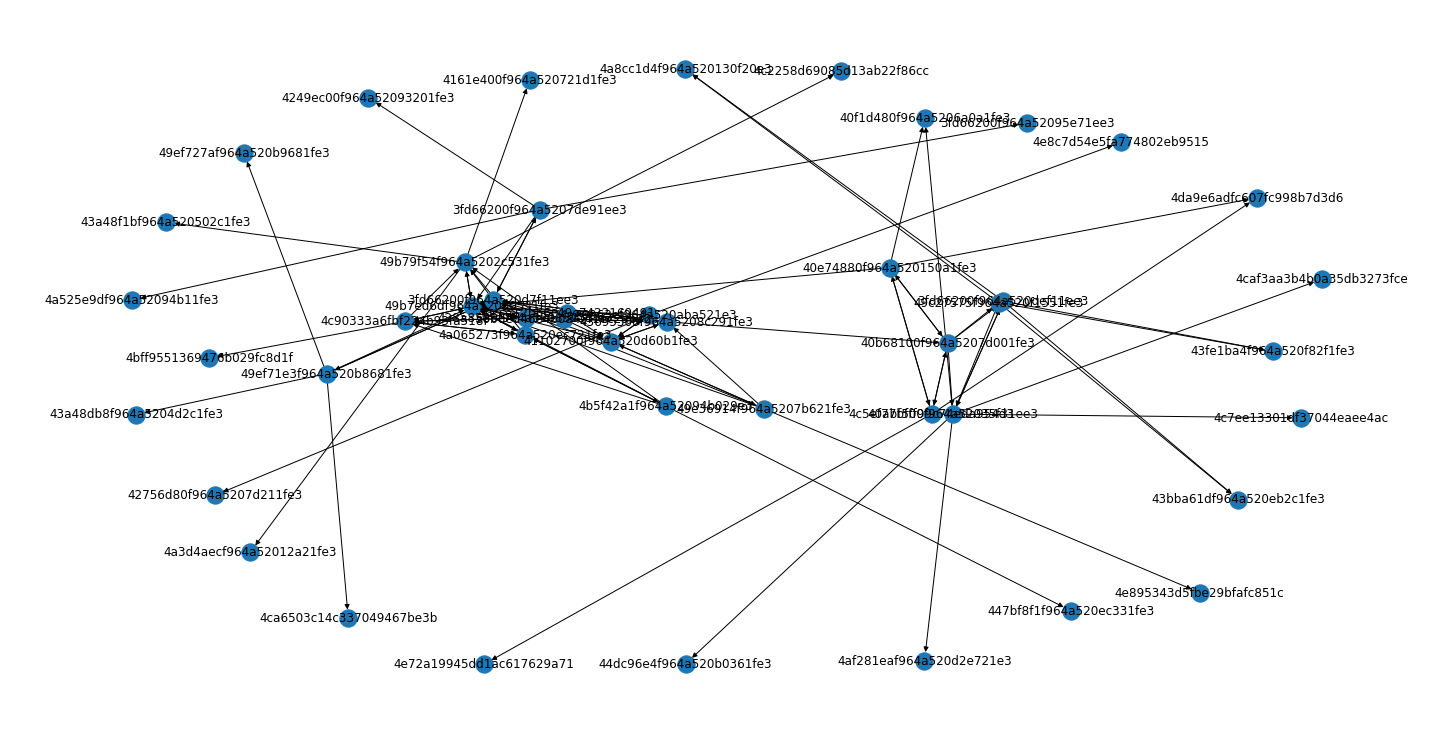

In [112]:
nx.draw(midtown_g, with_labels=True)

In [105]:
venues = midtown

degree = nx.degree(midtown_g)
venues['degree'] = [degree[n] for n in venues['id']]

pagerank = nx.pagerank(midtown_g, alpha=.9)
venues['pagerank'] = [pagerank[n] for n in venues['id']]

betweenness = nx.betweenness_centrality(midtown_g)
venues['betweenness'] = [betweenness[n] for n in venues['id']]

venues

,id,name,type,degree,pagerank,betweenness
0,43695300f964a5208c291fe3,Empire State Building,Building,12,0.052946,0.368333
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout,7,0.017244,0.026667
2,49b7ed6df964a52030531fe3,Times Square,Plaza,20,0.211604,0.204306
3,41102700f964a520d60b1fe3,Macy's,Department Store,10,0.025988,0.055000
4,40b68100f964a5207d001fe3,Madison Square Park,Park,8,0.021803,0.270000
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,14,0.100981,0.166667
6,50b6ed46e4b0a40f1ec2ab32,102nd Floor Observatory,Scenic Lookout,6,0.009168,0.000000
7,4a065273f964a520ec721fe3,M&M's World,Candy Store,9,0.079634,0.034722
8,428a8580f964a52083231fe3,Hard Rock Cafe,Theme Restaurant,8,0.075745,0.126250
9,49b79f54f964a5202c531fe3,Rockefeller Center,Plaza,6,0.098511,0.000000


In [126]:
downtown_g = generate_network_from_links(downtown, 'links_downtown.csv')
print(nx.info(downtown_g))

Name: 
Type: DiGraph
Number of nodes: 53
Number of edges: 115
Average in degree:   2.1698
Average out degree:   2.1698


In [127]:
westvil_g = generate_network_from_links(westvil, 'links_westvil.csv')
print(nx.info(westvil_g))

Name: 
Type: DiGraph
Number of nodes: 25
Number of edges: 40
Average in degree:   1.6000
Average out degree:   1.6000


In [132]:
comb = nx.compose(midtown_g, downtown_g)
comb = nx.compose(comb, westvil_g)

In [133]:
print(nx.info(comb))

Name: 
Type: DiGraph
Number of nodes: 107
Number of edges: 245
Average in degree:   2.2897
Average out degree:   2.2897


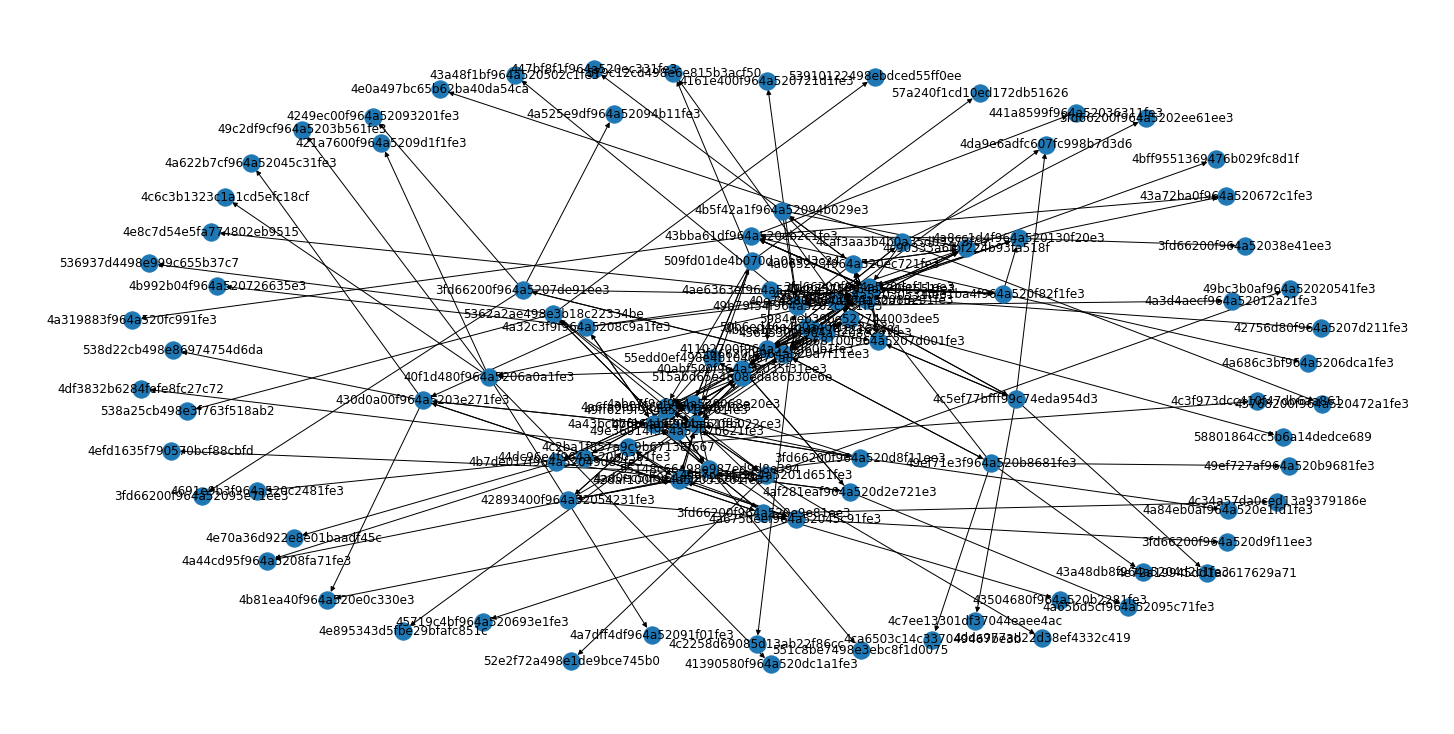

In [134]:
nx.draw(comb, with_labels=True)

In [106]:
labels = dict(zip(list(midtown['id']),list(midtown['name'])))
graph_pos = nx.spring_layout(midtown_g)
#graph_pos

{'43695300f964a5208c291fe3': Text(0.002674736174129075, -0.08290495811424563, 'Empire State Building'),
 '4bcca12bb6c49c7422169491': Text(-0.02122048483294385, -0.2592038671525056, '86th Floor Observation Deck'),
 '49b7ed6df964a52030531fe3': Text(-0.005590637265759034, -0.42706194813364445, 'Times Square'),
 '41102700f964a520d60b1fe3': Text(-0.006290680842386226, -0.2402057673338206, "Macy's"),
 '40b68100f964a5207d001fe3': Text(0.04084206729279846, 0.3949758118008543, 'Madison Square Park'),
 '3fd66200f964a520d7f11ee3': Text(-0.03424810693099812, -0.33198975650688445, 'Bryant Park'),
 '50b6ed46e4b0a40f1ec2ab32': Text(0.013193502567769992, -0.2598693395045515, '102nd Floor Observatory'),
 '4a065273f964a520ec721fe3': Text(0.02422709850377142, -0.4218238664776398, "M&M's World"),
 '428a8580f964a52083231fe3': Text(0.004876289102599094, -0.3006781251392948, 'Hard Rock Cafe'),
 '49b79f54f964a5202c531fe3': Text(-0.001967555078566925, -0.5360399664578902, 'Rockefeller Center'),
 '4c90333a6fbf2

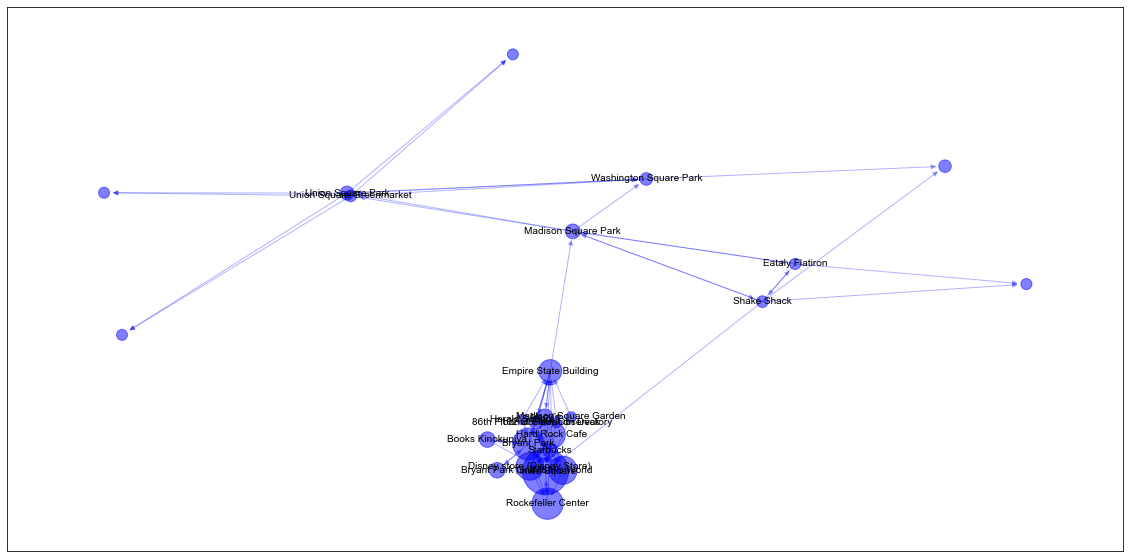

In [107]:
# Plot network

#fig = plt.figure(figsize(16,9), dpi=150)
nodesize = [10000 * n for n in pagerank.values()]
nx.draw_networkx_nodes(midtown_g, graph_pos, node_size=nodesize, alpha=.5, node_color='blue')
nx.draw_networkx_edges(midtown_g, graph_pos, width=1, alpha=.3, edge_color='blue')
nx.draw_networkx_labels(midtown_g, graph_pos, labels=labels, font_size=10, font_family='Arial')